<a href="https://colab.research.google.com/github/atharv946/Chromatin-Accessibility/blob/main/Step6a_CNN_with_attention_multi_head_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import pandas as pd

from keras.models import Sequential

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.optimizers import Adam

from keras.preprocessing.sequence import pad_sequences

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/1:1_Atharv_Gupta/Datasets/joined_train_random_1k.csv')
df_val = pd.read_csv('/content/drive/MyDrive/1:1_Atharv_Gupta/Datasets/joined_valid_random_1k.csv')

In [ ]:
df_train.head()

,signalValue,sequence,accessibility,accessibility.1
0,0.000000,AGATCCTGTGGTAGGAAGGACATTAGTGAGTATGAGGAATGGAAGA...,0.0,0.0
1,0.000000,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.0,0.0
2,0.471098,CTTAGAGTATCCGGACTGACACATAGGGAGGAGTGGGCAGAATAGC...,1.0,1.0
3,1.224850,GGTACAATAGTAAATAAGATAGGTAAGATAGTAACAGACTTAATGG...,1.0,1.0
4,4.020030,GAACCTGCTGAAATGCTGCAGGGATTTCAGGCAAGTTAGCCTTGGC...,1.0,1.0


In [ ]:
df_val.head()

,signalValue,sequence,accessibility,accessibility.1
0,1.38189,GACCTCGTGATCCACCCGCCTCGGCCTCCCAAAGTGCTGGGATTAC...,1.0,1.0
1,3.54894,TGGCGTTCCAGGATCGCCGCGCTTTCACCCCTCCCCGCGCCACTCT...,1.0,1.0
2,1.72736,AAAAATACAAAAATTAGCCAGGTGTAGTGGCATACGCCTGTAATCC...,1.0,1.0
3,1.06782,CATGCATTGATTCCTACATCAAGAGCCACGTGGGGTACATGTCATT...,1.0,1.0
4,7.12928,AGGTGACCCAGAAACTTAGTAATAAGGGAGTGGTTTCTCTGAAGTT...,1.0,1.0


In [ ]:
# Function to one-hot encode a sequence
def one_hot_encode(sequence, max_length):

    encoding = {'A': [1, 0, 0, 0],

                'C': [0, 1, 0, 0],

                'G': [0, 0, 1, 0],

                'T': [0, 0, 0, 1],

                'N': [0, 0, 0, 0]

                }

    # One-hot encode the sequence

    encoded_sequence = [encoding.get(base, [0, 0, 0, 0]) for base in sequence[:max_length]]

    # Pad to the maximum length by adding [0, 0, 0, 0] (which represents 'N' or padding)

    return pad_sequences([encoded_sequence], maxlen=max_length, dtype='int32', padding='post')[0]

In [ ]:
# Set the fixed sequence length
fixed_length = 1000

# One-hot encode all sequences in the DataFrame and truncate/pad to fixed length
X_train = np.array([one_hot_encode(seq, fixed_length) for seq in df_train['sequence']])

In [ ]:
# Extract labels
y_class_train = np.array(df_train['accessibility'])
y_reg_train = np.array(df_train['signalValue'])

In [ ]:
# Set the fixed sequence length
fixed_length = 1000


# One-hot encode all sequences in the DataFrame and truncate/pad to fixed length
X_val = np.array([one_hot_encode(seq, fixed_length) for seq in df_val['sequence']])

In [ ]:
y_class_val = np.array(df_val['accessibility'])
y_reg_val = np.array(df_val['signalValue'])

In [ ]:
import tensorflow as tf

from tensorflow.keras import layers, models, Input

In [ ]:
def create_cnn_transformer_model(input_shape):

    # Input layer
    inputs = Input(shape=(1000, 4, 1))

    # CNN Layers
    x = layers.Conv2D(filters=64, kernel_size=(13,4), activation='relu', padding='same')(inputs)
    x = layers.Conv2D(filters=64, kernel_size=(13,1), activation='relu', padding='same')(x)
    # x = layers.MultiHeadAttention(num_heads=8, key_dim=32)(x, x)
    x = layers.MaxPooling2D(pool_size=(5,1))(x)
    # Add more CNN layers as needed
    x = layers.Conv2D(filters=64, kernel_size=(7,1), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=64, kernel_size=(7,1), activation='relu', padding='same')(x)
    # x = layers.MultiHeadAttention(num_heads=8, key_dim=32)(x, x)
    x = layers.MaxPooling2D(pool_size=(5,1))(x)

    x = layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters=64, kernel_size=(5,1), activation='relu', padding='same')(x)
    # x = layers.MaxPooling2D(pool_size=(5,1))(x)

    # x = layers.Flatten()(x)
    # x = layers.Dropout(0.5)(x)


    # Prepare data for Transformer (Flatten and reduce dimensions)
    # x = layers.Dense(units=128, activation='relu')(x)


    # Reshape for Transformer compatibility
    # x = layers.Reshape(target_shape=(-1, 128))(x)


    # Transformer Block (using MultiHeadAttention)

    # The input here is reshaped to match the required shape for attention
    attention_output = layers.MultiHeadAttention(num_heads=8, key_dim=32)(x, x)
    # Add a Dense layer to process attention output
    x = layers.MaxPooling2D(pool_size=(5,1))(attention_output)

    x = layers.Flatten()(x)

    x = layers.Dense(units=64, activation='relu')(x)

    x = layers.Dense(units=32, activation='relu')(x)


    # Classification Head
    classification_output = layers.Dense(1, activation='sigmoid', name='classification_output')(x)

    # Regression Head
    regression_output = layers.Dense(1, activation='linear', name='regression_output')(x)


    # Model
    model = models.Model(inputs=inputs, outputs=[classification_output, regression_output])


    return model

In [ ]:
# Define input shape according to your data

input_shape = X_train.shape[1:]

model = create_cnn_transformer_model(input_shape)



# Compile the model

model.compile(

    optimizer = Adam(learning_rate=0.0001),
    loss={

        'classification_output': 'binary_crossentropy',

        'regression_output': 'mean_squared_error',

    },

    metrics={

        'classification_output': ['accuracy'],

        'regression_output': ['mse'],

    }

)



# Summary of the model

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1000, 4, 1)     │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 1000, 4, 64)    │          3,392 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 1000, 4, 64)    │         53,312 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 200, 4, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 200, 4, 64)     │         28,736 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 200, 4, 64)     │         28,736 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 40, 4, 64)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 40, 4, 64)      │         20,544 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 40, 4, 64)      │         20,544 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 40, 4, 64)      │         66,368 │ conv2d_5[0][0],        │
│ (MultiHeadAttention)      │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 8, 4, 64)       │              0 │ multi_head_attention[… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │        131,136 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 32)             │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classification_output     │ (None, 1)              │             33 │ dense_1[0][0]          │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ regression_output (Dense) │ (None, 1)              │             33 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 354,914 (1.35 MB)

 Trainable params: 354,914 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model

history = model.fit(

    X_train,

    {'classification_output': y_class_train, 'regression_output': y_reg_train},

    validation_data=(X_val, {'classification_output': y_class_val, 'regression_output': y_reg_val}),

    epochs=15,  # Specify the number of epochs

    batch_size=2,  # Specify the batch size

    verbose=1  # Verbosity mode

)

Epoch 1/15
58266/58266 ━━━━━━━━━━━━━━━━━━━━ 269s 4ms/step - classification_output_accuracy: 0.6067 - classification_output_loss: 0.6344 - loss: 3.1747 - regression_output_loss: 2.5403 - regression_output_mse: 2.5403 - val_classification_output_accuracy: 0.8330 - val_classification_output_loss: 0.3735 - val_loss: 2.1757 - val_regression_output_loss: 1.8021 - val_regression_output_mse: 1.8022
Epoch 2/15
58266/58266 ━━━━━━━━━━━━━━━━━━━━ 258s 4ms/step - classification_output_accuracy: 0.8435 - classification_output_loss: 0.3595 - loss: 2.2810 - regression_output_loss: 1.9214 - regression_output_mse: 1.9214 - val_classification_output_accuracy: 0.8714 - val_classification_output_loss: 0.3058 - val_loss: 1.9104 - val_regression_output_loss: 1.6045 - val_regression_output_mse: 1.6046
Epoch 3/15
58266/58266 ━━━━━━━━━━━━━━━━━━━━ 258s 4ms/step - classification_output_accuracy: 0.8722 - classification_output_loss: 0.3032 - loss: 2.0106 - regression_output_loss: 1.7074 - regression_output_mse: 1.7

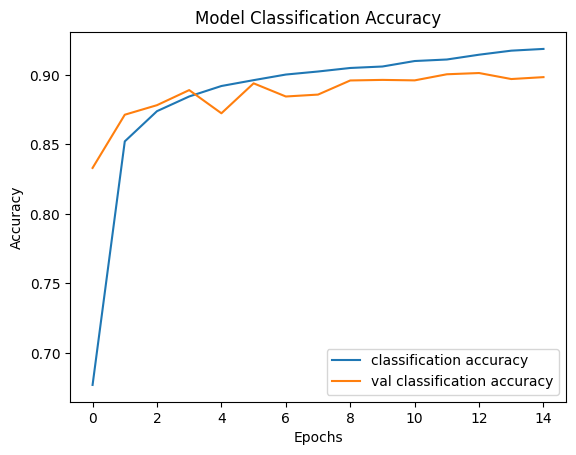

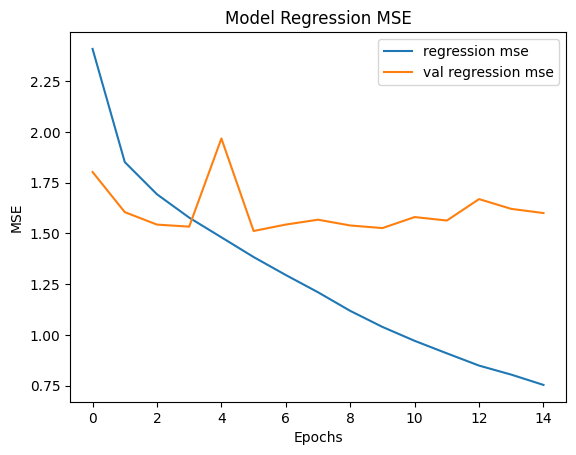

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['classification_output_accuracy'], label='classification accuracy')

plt.plot(history.history['val_classification_output_accuracy'], label='val classification accuracy')

plt.title('Model Classification Accuracy')

plt.xlabel('Epochs')

plt.ylabel('Accuracy')

plt.legend()

plt.show()



plt.plot(history.history['regression_output_mse'], label='regression mse')

plt.plot(history.history['val_regression_output_mse'], label='val regression mse')

plt.title('Model Regression MSE')

plt.xlabel('Epochs')

plt.ylabel('MSE')

plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test dataset
val_score = model.evaluate(X_val, y_class_val, verbose=1)

print(f'Accuracy on validation set: {val_score[1] * 100}%')

456/456 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - classification_output_accuracy: 0.8963 - classification_output_loss: 0.2690 - loss: 0.2691 - regression_output_loss: 0.0000e+00 - regression_output_mse: 0.0000e+00
Accuracy on validation set: 26.280835270881653%


In [ ]:
model.save("/content/drive/MyDrive/1:1_Atharv_Gupta/Models/best_model_CNN_attention_with_multi_output.h5")